In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os, sys, subprocess, json, argparse
from itertools import product
from collections import defaultdict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

dir_root = ''
# If using google colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    dir_root = '/content/drive/MyDrive/Colab Notebooks/ESE546/hw5'

print("dir_root:", dir_root)

device: cuda
Mounted at /content/drive/
dir_root: /content/drive/MyDrive/Colab Notebooks/ESE546/hw5


In [3]:
# Download the MNIST dataset (skip if already exists)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.15MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [4]:
# Create dictionaries to store indices for each digit
digit_to_indices = defaultdict(list)

# Get indices for each digit in the training set
for idx, (_, label) in enumerate(train_dataset):
    digit_to_indices[label].append(idx)

# Extract 1000 images per digit and subsample to 14x14
images_per_digit = 1000
target_size = 14
extracted_images = {}
extracted_labels = {}

for digit in range(10):
    # Randomly sample 1000 indices for this digit
    selected_indices = np.random.choice(digit_to_indices[digit], images_per_digit, replace=False)

    digit_images = []
    digit_labels = []

    for idx in selected_indices:
        image, label = train_dataset[idx]
        
        # Subsample image to 14x14
        image = image.unsqueeze(0)
        image = F.interpolate(image, size=(target_size, target_size), mode='bilinear', align_corners=False)
        image = image.squeeze(0)

        digit_images.append(image)
        digit_labels.append(label)

    # Stack the images and labels
    extracted_images[digit] = torch.stack(digit_images)
    extracted_labels[digit] = torch.tensor(digit_labels)

# Combine all digits into single tensors
all_images = torch.cat([extracted_images[d] for d in range(10)])  # Shape: [10000, 1, 14, 14]
all_images = (all_images > 0.5).float()  # Binarize the images
all_labels = torch.cat([extracted_labels[d] for d in range(10)])  # Shape: [10000]

torch.Size([10000, 1, 14, 14])
torch.Size([10000])
Digit 0 has 1000 images
Digit 1 has 1000 images
Digit 2 has 1000 images
Digit 3 has 1000 images
Digit 4 has 1000 images
Digit 5 has 1000 images
Digit 6 has 1000 images
Digit 7 has 1000 images
Digit 8 has 1000 images
Digit 9 has 1000 images


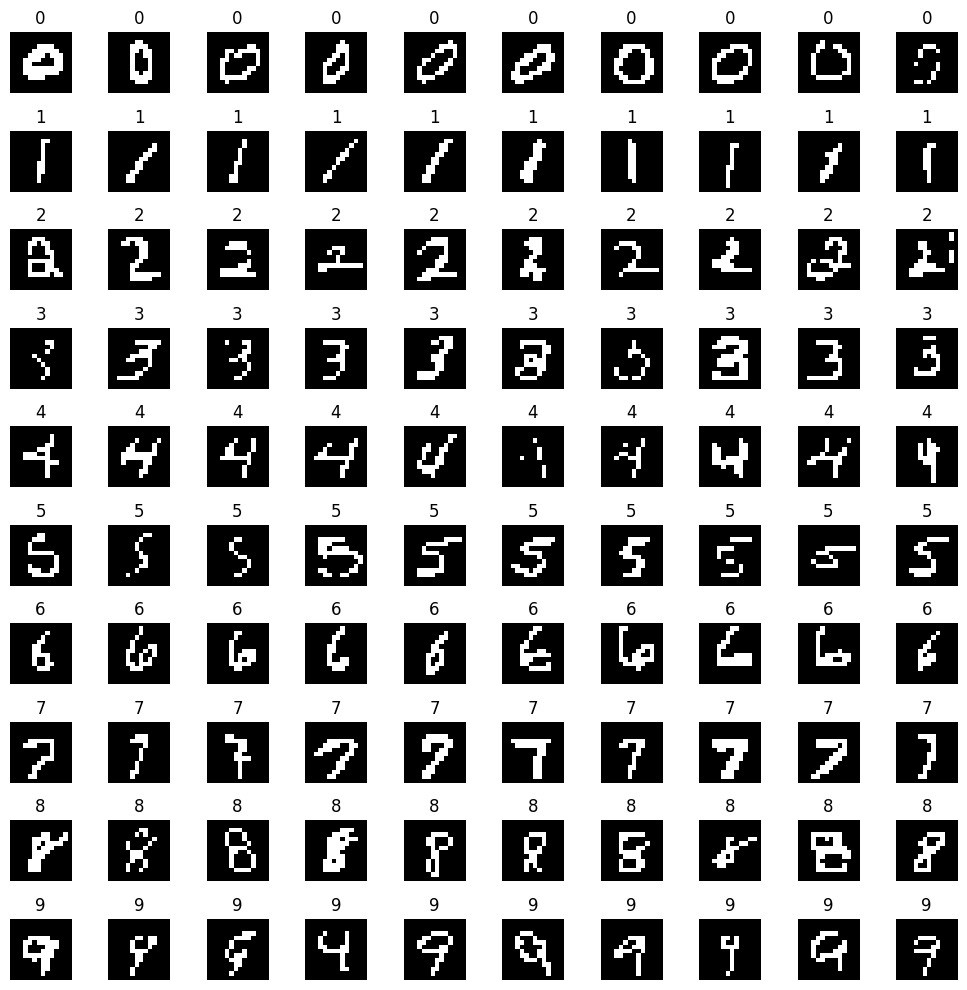

In [5]:
# Validate the dataset

print(all_images.shape)  # Shape: [10000, 1, 14, 14]
print(all_labels.shape)  # Shape: [10000]

# Check if each digit has 1000 images
for digit in range(10):
    num_images = (all_labels == digit).sum().item()
    print(f"Digit {digit} has {num_images} images")

# Randomly visualize 10 images per label to check if labels and images correspond
def visualize_random_images_per_label(images, labels, num_images=10):
    fig, axs = plt.subplots(10, num_images, figsize=(num_images, 10))

    for digit in range(10):
        digit_indices = (labels == digit).nonzero(as_tuple=True)[0]
        # Randomly select num_images indices
        selected_indices = np.random.choice(digit_indices, num_images, replace=False)

        for i, idx in enumerate(selected_indices):
            axs[digit, i].imshow(images[idx].squeeze(0), cmap='gray')
            axs[digit, i].axis('off')
            axs[digit, i].set_title(labels[idx].item())

    plt.tight_layout()
    plt.show()

visualize_random_images_per_label(all_images, all_labels)

torch.Size([100, 1, 14, 14])
torch.Size([100])


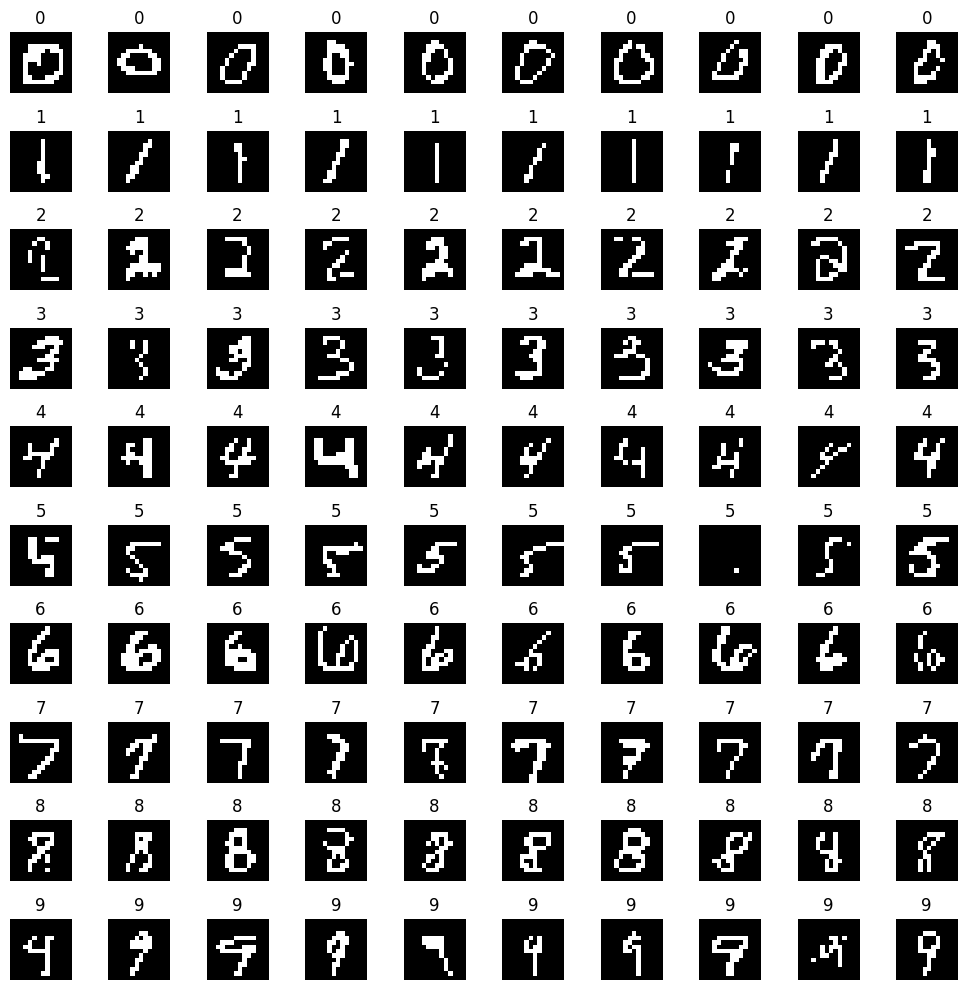

In [17]:
# Create validation dataset (similar to how training data was created)
val_digit_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(test_dataset):
    val_digit_to_indices[label].append(idx)

# Sample 100 images from test set (10 per digit)
images_per_digit_val = 10
val_images = []
val_labels = []

for digit in range(10):
    selected_indices = np.random.choice(val_digit_to_indices[digit], images_per_digit_val, replace=False)

    for idx in selected_indices:
        image, label = test_dataset[idx]
        image = image.unsqueeze(0)
        image = F.interpolate(image, size=(target_size, target_size), mode='bilinear', align_corners=False)
        image = image.squeeze(0)
        image = (image > 0.5).float()  # Binarize

        val_images.append(image)
        val_labels.append(label)

val_images = torch.stack(val_images)
val_labels = torch.tensor(val_labels)

print(val_images.shape)  # Shape: [100, 1, 14, 14]
print(val_labels.shape)  # Shape: [100]

visualize_random_images_per_label(val_images, val_labels)


In [31]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder (14x14=196 inputs -> 128 -> 16 for mean and std dev)
        self.encoder_fc1 = nn.Linear(14 * 14, 128)
        self.encoder_fc2 = nn.Linear(128, 16)  # 8 for mean, 8 for std dev

        # Decoder (8 -> 128 -> 196 outputs)
        self.decoder_fc1 = nn.Linear(8, 128)
        self.decoder_fc2 = nn.Linear(128, 14 * 14)

    def encode(self, x):
        # Flatten the input
        x = x.view(-1, 14 * 14)

        h1 = torch.tanh(self.encoder_fc1(x))
        h2 = self.encoder_fc2(h1)

        # Split into mean and log_var
        mean = h2[:, :8]
        log_var = h2[:, 8:]
        return mean, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.tanh(self.decoder_fc1(z))
        h4 = torch.sigmoid(self.decoder_fc2(h3))

        return h4.view(-1, 1, 14, 14)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def loss_function(model, x, mu, log_var):
    # Sample z twice and average the reconstruction loss
    z1 = model.reparameterize(mu, log_var)
    recon_x1 = model.decode(z1)
    z2 = model.reparameterize(mu, log_var)
    recon_x2 = model.decode(z2)

    # Compute log p_v(x|z) for both samples using Bernoulli log probability
    log_p1 = torch.sum(
        x.view(-1, 14*14) * torch.log(recon_x1.view(-1, 14*14) + 1e-8) +
        (1-x.view(-1, 14*14)) * torch.log(1-recon_x1.view(-1, 14*14) + 1e-8),
        dim=1
    )
    log_p2 = torch.sum(
        x.view(-1, 14*14) * torch.log(recon_x2.view(-1, 14*14) + 1e-8) +
        (1-x.view(-1, 14*14)) * torch.log(1-recon_x2.view(-1, 14*14) + 1e-8),
        dim=1
    )
    expected_log_p = 0.5 * (log_p1 + log_p2).mean()

    # KL divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    return -(expected_log_p - KLD), -expected_log_p, KLD

def compute_validation_likelihood(model, val_images):
    model.eval()
    with torch.no_grad():
        recon_batch, mu, log_var = model(val_images.to(device))
        _, log_likelihood, _ = loss_function(model, val_images.to(device), mu, log_var)
    return log_likelihood.item()


In [41]:
# Setup training
batch_size = 2048
n_epochs = 500
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(all_images),
    batch_size=batch_size, shuffle=True)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

expected_log_p_history = []
kld_history = []
train_log_likelihood = []
val_log_likelihood = []

updates_counter = 0

# Training loop
for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0
    total_expected_log_p = 0
    total_kld = 0
    num_batches = 0

    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)
        loss, expected_log_p, kld = loss_function(model, data, mu, log_var)
        loss.backward()
        optimizer.step()

        num_batches += 1
        updates_counter += 1

        # Record training log likelihood
        train_log_likelihood.append(expected_log_p.item())

        # Record expected log probability and KL divergence at each weight update
        expected_log_p_history.append(expected_log_p.item())
        kld_history.append(kld.item())

        # Accumulate values for epoch averages
        train_loss += loss.item()
        total_expected_log_p += expected_log_p.item()
        total_kld += kld.item()

        # Compute validation metrics every 100 updates
        if updates_counter % 100 == 0:
            val_ll = compute_validation_likelihood(model, val_images)
            val_log_likelihood.append(val_ll)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Average loss = {(train_loss / num_batches):.4f}')

Epoch 10: Average loss = 60.3417
Epoch 20: Average loss = 52.8752
Epoch 30: Average loss = 49.0881
Epoch 40: Average loss = 46.0293
Epoch 50: Average loss = 43.8138
Epoch 60: Average loss = 42.5172
Epoch 70: Average loss = 41.7658
Epoch 80: Average loss = 41.2805
Epoch 90: Average loss = 40.8869
Epoch 100: Average loss = 40.4849
Epoch 110: Average loss = 40.1604
Epoch 120: Average loss = 39.8627
Epoch 130: Average loss = 39.5038
Epoch 140: Average loss = 39.2210
Epoch 150: Average loss = 38.9365
Epoch 160: Average loss = 38.6800
Epoch 170: Average loss = 38.4129
Epoch 180: Average loss = 38.1872
Epoch 190: Average loss = 37.9377
Epoch 200: Average loss = 37.7249
Epoch 210: Average loss = 37.5135
Epoch 220: Average loss = 37.2762
Epoch 230: Average loss = 37.0629
Epoch 240: Average loss = 36.8796
Epoch 250: Average loss = 36.6969
Epoch 260: Average loss = 36.5294
Epoch 270: Average loss = 36.3542
Epoch 280: Average loss = 36.2210
Epoch 290: Average loss = 36.1322
Epoch 300: Average loss

(iii) Plot the first and second term of ELBO in Eq. (1) separately as a function of the number of weight updates.

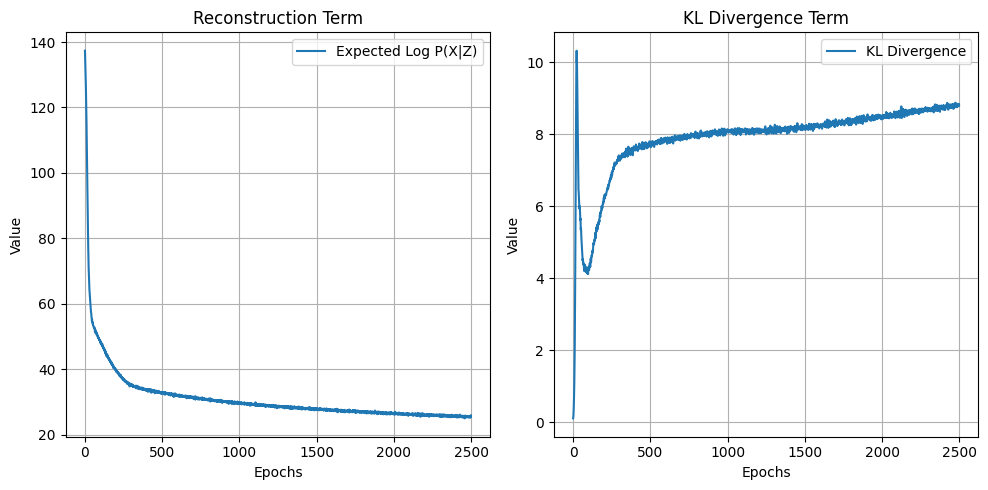

In [42]:
# Plot the first and second term of ELBO in Eq. (1) separately as a function of the number of weight updates.

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(expected_log_p_history, label='Expected Log P(X|Z)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Reconstruction Term')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(kld_history, label='KL Divergence')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('KL Divergence Term')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

(iv) Pick 8 MNIST images, run them through the encoder and the decoder to plot the output of the decoder side-by-side with the original images.

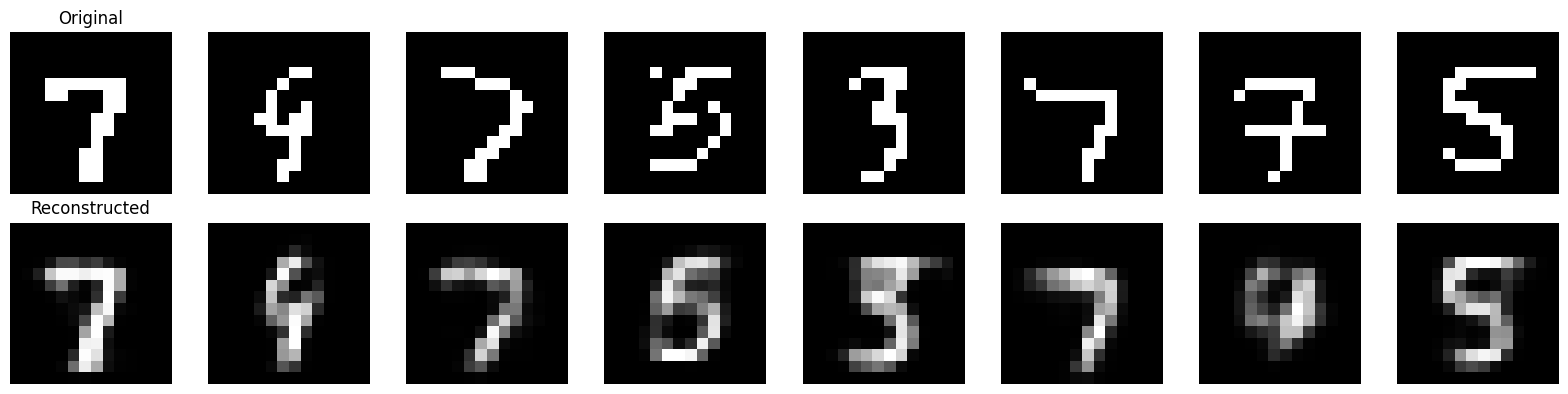

In [43]:
# Pick 8 MNIST images, run them through the encoder and the decoder to plot the original and reconstructed images side by side

selected_indices = np.random.choice(len(all_images), 8, replace=False)
selected_images = all_images[selected_indices]

with torch.no_grad():
    recon_images, _, _ = model(selected_images.to(device))

fig, axs = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    axs[0, i].imshow(selected_images[i].squeeze(0), cmap='gray')
    axs[0, i].axis('off')
    if i == 0:
        axs[0, i].set_title('Original', fontsize=12)

    axs[1, i].imshow(recon_images[i].squeeze(0).cpu(), cmap='gray')
    axs[1, i].axis('off')
    if i == 0:
        axs[1, i].set_title('Reconstructed', fontsize=12)

plt.tight_layout()
plt.show()

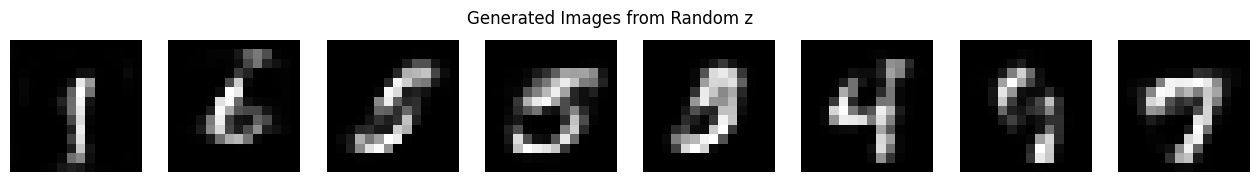

In [44]:
# (v) Sample from the generative model directly

def generate_samples(model, num_samples=8):
    with torch.no_grad():
        z = torch.randn(num_samples, 8).to(device)
        generated_images = model.decode(z)

    # Plot the generated images
    fig, axs = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
    for i in range(num_samples):
        axs[i].imshow(generated_images[i].cpu().squeeze(0), cmap='gray')
        axs[i].axis('off')
    plt.suptitle('Generated Images from Random z')
    plt.show()

generate_samples(model)

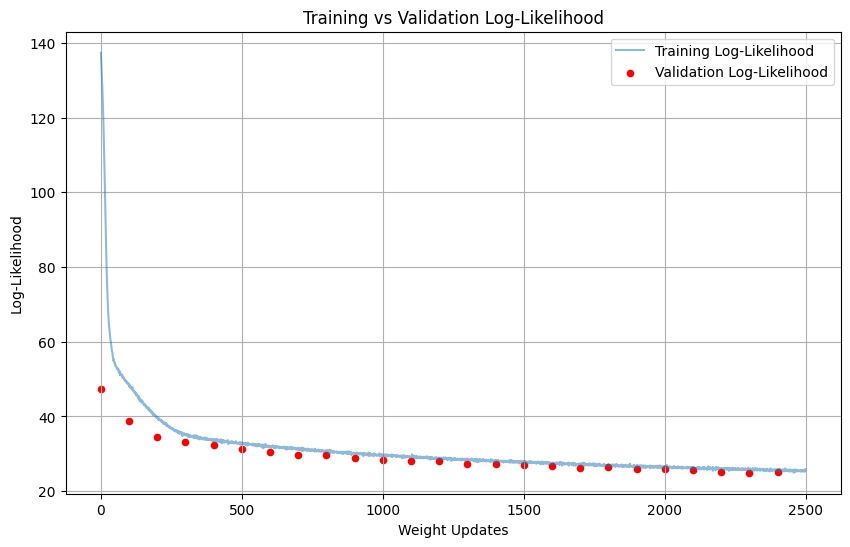

In [45]:
# (vi) Plot validation performance

plt.figure(figsize=(10, 6))
plt.plot(train_log_likelihood, label='Training Log-Likelihood', alpha=0.5)
plt.scatter(np.arange(0, len(train_log_likelihood), 100), val_log_likelihood,
            label='Validation Log-Likelihood', color='red', s=20)
plt.xlabel('Weight Updates')
plt.ylabel('Log-Likelihood')
plt.title('Training vs Validation Log-Likelihood')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Shut down if it's google colab
# First sleep for a while so that changes to the notebook are saved
import time
time.sleep(30)

if 'google.colab' in str(get_ipython()):
    from google.colab import runtime
    runtime.unassign()